In [1]:
import xarray as xr
import salem as sa
from cdo import Cdo
from pathlib import Path
import matplotlib.pyplot as plt
import darwin
import numpy as np

In [2]:
# constants
basepath = Path('/home/ben/data/GAR/rc_trop_ls_MM/')
variable = "et"
enso_event = "nino"
cdo = Cdo()
combinations = {
    "nina": ["2010", "2011"],
    "nino": ["2015", "2016"],
    "neutral": ["2016", "2017"],
}

# naming rc_trop_ls_MM_d02km_m_2d_v10_2022.nc

In [3]:
def make_path(basepath: Path, year, variable):
    return basepath / f"rc_trop_ls_MM_d02km_d_2d_{variable}_{year}.nc"

def hydro_year(ifile1: Path, ifile2:Path, ofile=False):
    variable = ifile1.stem.split("_")[-2]
    year1 = ifile1.stem.split("_")[-1]
    year2 = ifile2.stem.split("_")[-1]
    cdo = Cdo()
    return cdo.seldate(
        f"{year1}-11-01,{year2}-01-31",
        input = f"-cat {ifile1} {ifile2}",
        ofile=ofile,
        returnXDataset = variable
    )

In [4]:
nina = hydro_year(
    make_path(basepath, combinations["nina"][0], variable),
    make_path(basepath, combinations["nina"][1], variable),
)
nino = hydro_year(
    make_path(basepath, combinations["nino"][0], variable),
    make_path(basepath, combinations["nino"][1], variable),
)
neutral = hydro_year(
    make_path(basepath, combinations["neutral"][0], variable),
    make_path(basepath, combinations["neutral"][1], variable),
)
# nino = nino.drop([np.datetime64('2016-02-29')], dim='time')

In [5]:
oceans = sa.read_shapefile(sa.get_demo_file('ne_50m_ocean.shp'),
                              cached=True)
nina_land = nina.salem.roi(shape=oceans, all_touched=False)
neutral_land = neutral.salem.roi(shape=oceans, all_touched=False)
nino_land = nino.salem.roi(shape=oceans, all_touched=False)

In [6]:
def plot_map(ds, name, **kwargs):
    fig, ax = plt.subplots(figsize=(16,14), sharex=True, sharey=True, )
    ds = ds.remove_boundaries(40)
    ds.plot_map(ax=ax, **kwargs)
    plt.savefig(f"rc_trop_ls_MM_{variable}_sum_map_{name}.png")
    plt.show()

Getting variable name translations
Adding measurements to dataset
Getting variable name translations


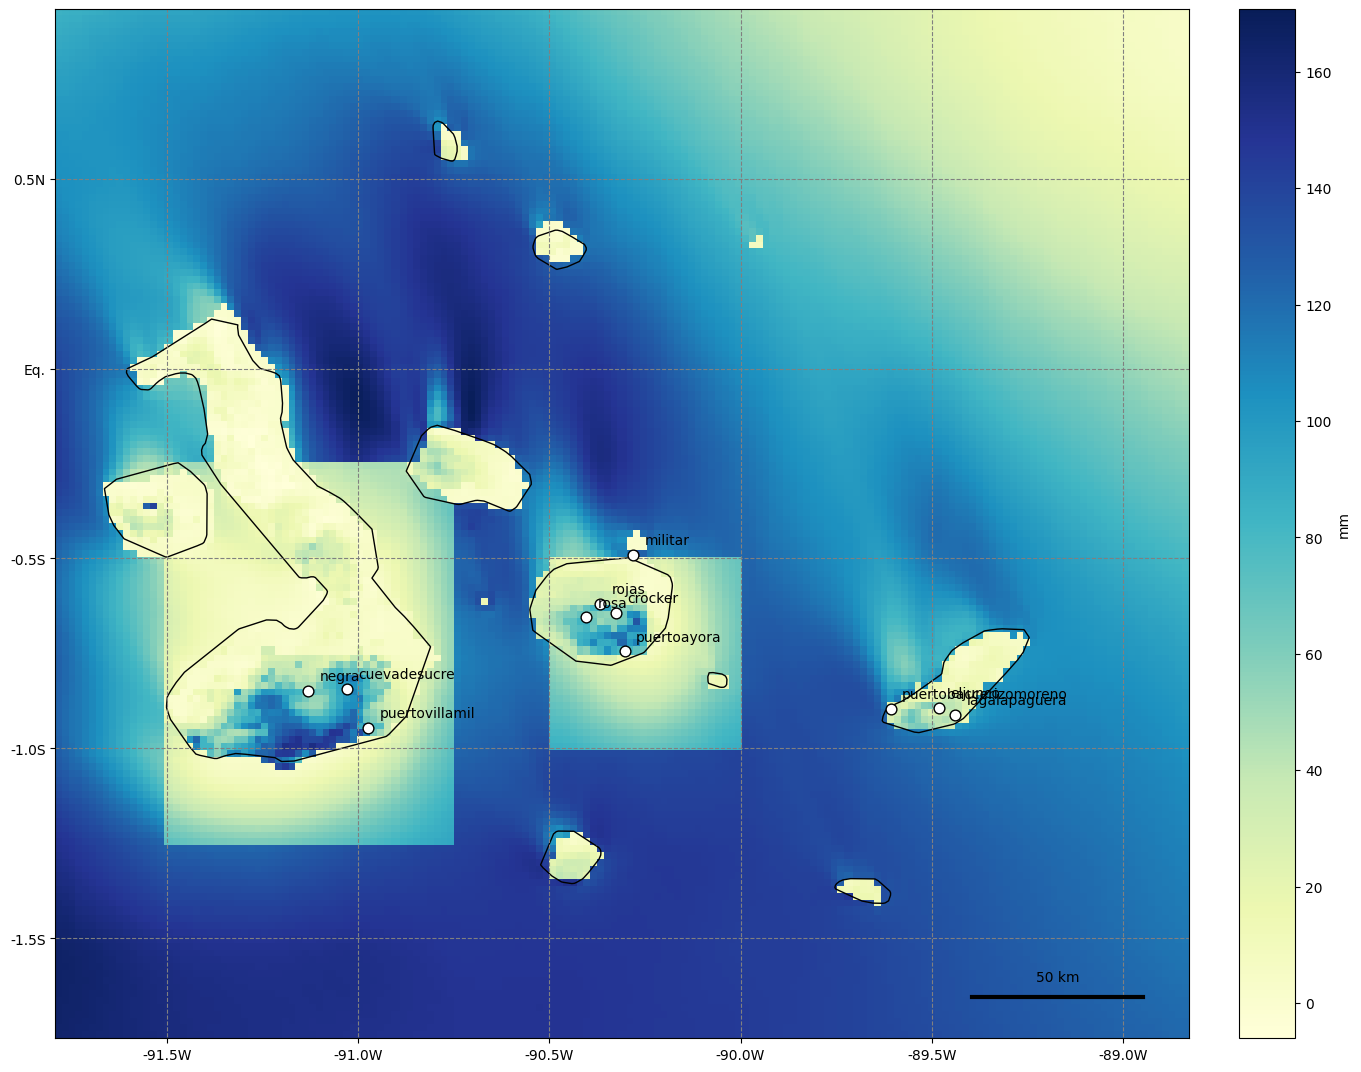

<Figure size 640x480 with 0 Axes>

In [7]:
from importlib import reload
reload(darwin)

plot_map_args = {
    "aggregation":"sum", 
    "save": False, 
    "stations": True, 
    "cbar": True, 
    "unit":'mm', 
    "cmap":'coolwarm', 
    # "vmax":1500
}

# plot_map_args["vmax"] = 1000
# plot_map_args["vmin"] = 0
plot_map_args["cmap"] = "YlGnBu"
diff = nina.copy()
diff[variable].data = nino[variable].data - nina[variable].data
diff.attrs = neutral.attrs
ds = darwin.Experiment(diff)
plot_map(ds, name=enso_event, **plot_map_args)
plt.savefig(f"rc_trop_ls_MM_{variable}_sum_map_nino-nina.png")

Getting variable name translations
Adding measurements to dataset
Getting variable name translations


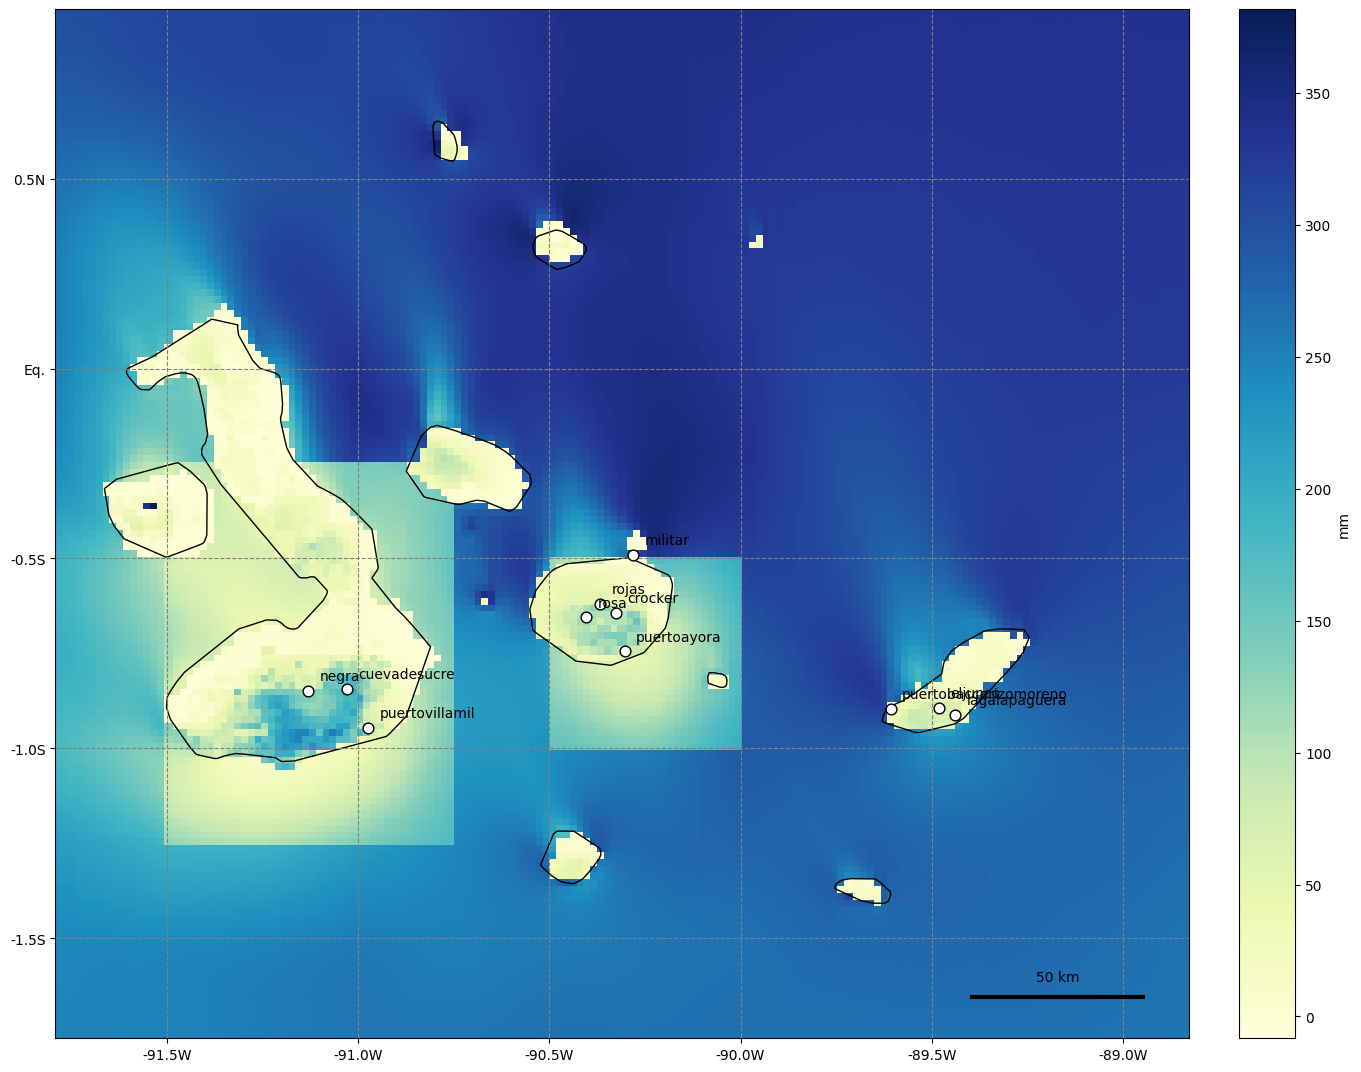

<Figure size 640x480 with 0 Axes>

In [47]:
ds = darwin.Experiment(globals()[enso_event])
plot_map(ds, name=enso_event, **plot_map_args)
plt.savefig(f"rc_trop_ls_MM_{variable}_sum_map_{enso_event}.png")

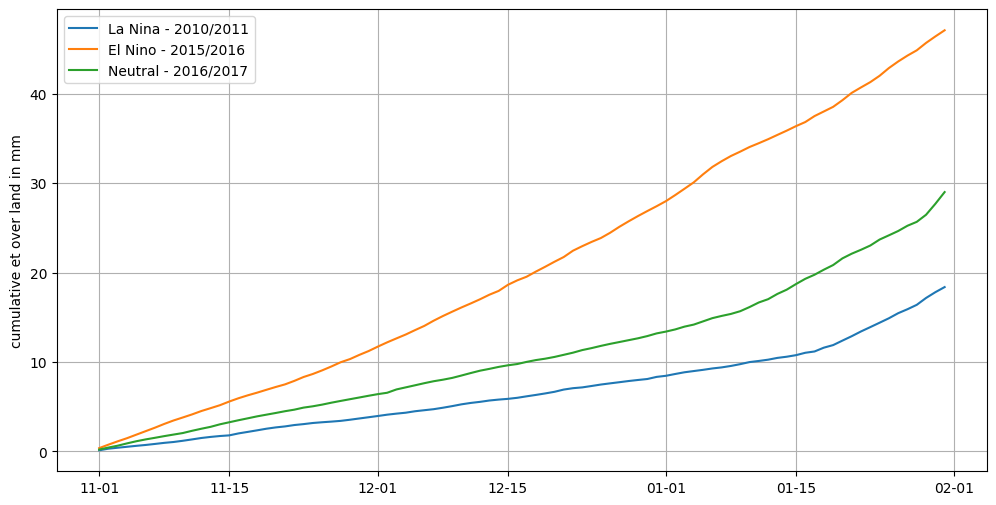

In [48]:
fig = plt.figure(figsize=(12, 6))
plt.plot(nina_land.time, (24 * nina_land.mean(dim=("west_east", "south_north")).cumsum()[variable]), label="La Nina - 2010/2011")
plt.plot(nina_land.time, (24 * nino_land.mean(dim=("west_east", "south_north")).cumsum()[variable]), label="El Nino - 2015/2016")
plt.plot(nina_land.time, (24 * neutral_land.mean(dim=("west_east", "south_north")).cumsum()[variable]), label="Neutral - 2016/2017")
locs, labels = plt.xticks()
plt.xticks(locs, ['11-01', '11-15', '12-01', '12-15', '01-01', '01-15', '02-01'])
plt.grid()
plt.legend()
# plt.tight_layout()
plt.ylabel(f"cumulative {variable} over land in mm")
plt.savefig(f"rc_trop_ls_MM_{variable}_cumsum_line_nino-nina-neutral.png")
plt.show()